## ML Lab-7

### Sai Sharanya Y 
### 19BTRCR043

### Build a simple reinforcement learning model and use Montel Carlo learning to find the optimal combination of products using meal data with 4 ingredients and 9 products.

***

In [1]:
# importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import time


In [2]:
# reading the CSV file
data = pd.read_csv("/content/SampleData.csv")


In [3]:
data

,Ingredient,Product,QMerged_label,Real_Cost,V_0
0,1,1,11,10,0
1,1,2,12,6,0
2,2,1,21,8,0
3,2,2,22,11,0
4,3,1,31,3,0
5,3,2,32,7,0
6,4,1,41,8,0
7,4,2,42,5,0
8,4,3,43,1,0


In [4]:
def MCModelv1(data, alpha, e, epsilon, budget, reward):
    # Define the States
    Ingredients = list(set(data['Ingredient']))
    # Initialise V_0
    V0 = data['V_0']
    data['V'] = V0
    output = []
    output1 = []
    output2 = []
    actioninfull = []
    #Interate over the number of episodes specified
    for e in range(0,e):
        
        episode_run = []
        #Introduce epsilon-greedy selection, we randomly select the first episode as V_0(a) = 0 for all actions
        epsilon = epsilon
        if e == 0:
            for i in range(0,len(Ingredients)):
                episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
            episode_run = episode_run.astype(int)
        
        else:
            for i in range(0,len(Ingredients)):
                greedyselection = np.random.random_integers(low = 1, high =10)
                if greedyselection <= (epsilon)*10:
                    episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
                else:
                    data_I = data[data['Ingredient'] == (i+1)] 
                    MaxofVforI = data_I[data_I['V'] == data_I['V'].max() ]['Product']
                    #If multiple max values, take first
                    MaxofVforI = MaxofVforI.values[0]
                    episode_run = np.append(episode_run, MaxofVforI)
                    
                episode_run = episode_run.astype(int)
                
               
           
        episode = pd.DataFrame({'Ingredient' : Ingredients, 'Product': episode_run})    
        episode['Merged_label'] =  (episode['Ingredient']*10 + episode['Product']).astype(float)
        data['QMerged_label'] = (data['QMerged_label']).astype(float)
        data['Reward'] = reward
        episode2 =  episode.merge(data[['QMerged_label','Real_Cost','Reward']], left_on='Merged_label',right_on='QMerged_label', how = 'inner')
        data = data.drop('Reward',1)
        
        # Calculate our terminal reward
        if(budget >= episode2['Real_Cost'].sum()):
            Return = 1  
        else:
            Return = -1 
        episode2 = episode2.drop('Reward',1)
        episode2['Return'] = Return
        
        # Apply update rule to actions that were involved in obtaining terminal reward 
        data = data.merge(episode2[['Merged_label','Return']], left_on='QMerged_label',right_on='Merged_label', how = 'outer')
        data['Return'] = data['Return'].fillna(0)
        for v in range(0,len(data)):
            if data.iloc[v,7] == 0:
                data.iloc[v,5] = data.iloc[v,5] 
            else:
                data.iloc[v,5]  = data.iloc[v,5]  + alpha*( (data.iloc[v,7]/len(Ingredients)) - data.iloc[v,5] )
                
        # Output table    
        data = data.drop('Merged_label',1)
        data = data.drop('Return',1)
        
        # Output is the Sum of V(a) for all episodes
        output  = np.append(output, data.iloc[:,-1].sum())
        
        # Output 1 and 2 are the Sum of V(a) for for the cheapest actions and rest respectively
        # I did this so we can copare how they converge whilst applying to such a small sample problem
        output1 = np.append(output1, data.iloc[[1,2,4,8],-1].sum())
        output2 = np.append(output2, data.iloc[[0,3,5,6,7],-1].sum())
        
        # Ouput to optimal action from the model based on highest V(a)
        action = pd.DataFrame(data.groupby('Ingredient')['V'].max())
        action2 = action.merge(data, left_on = 'V',right_on = 'V', how = 'inner')
        action3 = action2[['Ingredient','Product']]
        action3 = action3.groupby('Ingredient')['Product'].apply(lambda x :x.iloc[np.random.randint(0, len(x))])
        
        # Output the optimal action at each episode so we can see how this changes over time
        actioninfull = np.append(actioninfull, action3)
        actioninfull = actioninfull.astype(int)
        
        # Rename for clarity
        SumofV = output
        SumofVForCheapest = output1
        SumofVForExpensive = output2
        OptimalActions = action3
        ActionsSelectedinTime = actioninfull
        
    return(SumofV, SumofVForCheapest, SumofVForExpensive, OptimalActions, data, ActionsSelectedinTime)




In [5]:
!pip install chart-studio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.8 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=d086cba0f2ca5403bf68dd5234c65bd1bd4f050dfd5ca2678bc5522df8868ad4
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [6]:
from chart_studio.plotly import plot, iplot
from plotly.offline import iplot

In [7]:
alpha = 0.1
num_episodes = 100
epsilon = 0.5
budget = 30

# Currently not using a reward
reward = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl = MCModelv1(data=data, alpha = alpha, e = num_episodes,epsilon = epsilon, budget = budget, reward = reward)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.621019124984741 seconds ---


In [8]:
# Provide all parameters fixed except alpha
budget7 = 23
num_episodes7 = 100
alpha7  = 0.05

# Currently not using a reward
reward7 = [0,0,0,0,0,0,0,0,0]

VforInteractiveGraphA_3 = []    
lA3 = []
num_episodes7_3 = []
for x in range(0, 11):
    epsilon7 = 1 - x/10
    Mdl7 = MCModelv1(data=data, alpha = alpha7, e = num_episodes7,epsilon = epsilon7, budget = budget7, reward = reward7)
    VforInteractiveGraphA_3 = np.append(VforInteractiveGraphA_3, Mdl7[0])
    for y in range(0, num_episodes7):
        lA3 = np.append(lA3,epsilon7)
        num_episodes7_3 = np.append(num_episodes7_3, y)
VforInteractiveGraphA_32 = pd.DataFrame(VforInteractiveGraphA_3,lA3)
VforInteractiveGraphA_32['index1'] = VforInteractiveGraphA_32.index
VforInteractiveGraphA_32['Episode'] = num_episodes7_3
VforInteractiveGraphA_32.columns = ['V', 'Epsilon', 'Episode']
VforInteractiveGraphA_32 = VforInteractiveGraphA_32[['Epsilon','Episode', 'V']]


VforInteractiveGraphA_33 = VforInteractiveGraphA_32
VforInteractiveGraphA_33['continent'] = 'Test'
VforInteractiveGraphA_33['country'] = 'Test2'
VforInteractiveGraphA_33['pop'] = 7000000.0
VforInteractiveGraphA_33.columns = ['year', 'lifeExp', 'gdpPercap', 'continent', 'country', 'pop']

epsilonforGraph3 = list(set(VforInteractiveGraphA_33['year']))
epsilonforGraph3 = np.round(epsilonforGraph3,1)
epsilonforGraph3 = np.sort(epsilonforGraph3)[::-1]
years = np.round([(epsilonforGraph3) for epsilonforGraph3 in epsilonforGraph3],1)
years

%matplotlib inline

dataset = VforInteractiveGraphA_33

continents = []
for continent in dataset['continent']:
    if continent not in continents:
        continents.append(continent)
# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['title'] = "Parameter Optimisation using Interactive Animation <br> PhilipOsborneData.com"
figure['layout']['xaxis'] = {'title': 'Episode'}
figure['layout']['yaxis'] = {'title': 'Sum of V', 'type': 'linear'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1952',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Epsilon: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
year = 1.0
for continent in continents:
    dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

    data_dict = {
        'x': list(dataset_by_year_and_cont['lifeExp']),
        'y': list(dataset_by_year_and_cont['gdpPercap']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['country']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 200000,
            'size': list(dataset_by_year_and_cont['pop'])
        },
        'name': continent
    }
    figure['data'].append(data_dict)

# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for continent in continents:
        dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

        data_dict = {
            'x': list(dataset_by_year_and_cont['lifeExp']),
            'y': list(dataset_by_year_and_cont['gdpPercap']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['country']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 200000,
                'size': list(dataset_by_year_and_cont['pop']),
                'color': 'rgba(255, 182, 193, .9)'
            },
            'name': continent
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)


figure['layout']['sliders'] = [sliders_dict]

iplot(figure)


--- 20.509032011032104 seconds ---


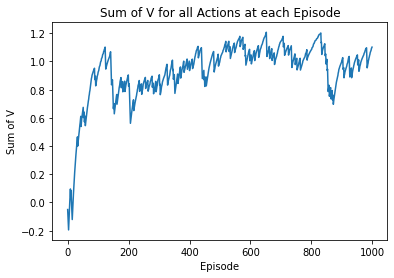

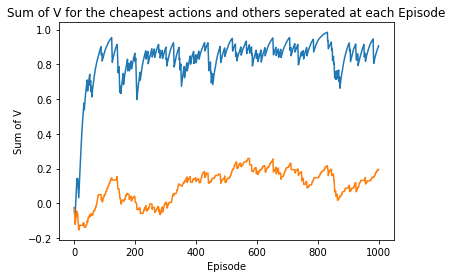

In [9]:
# Increase the number of episodes

budget8 = 23
alpha8 = 0.05
num_episodes8 = 1000
epsilon8 = 0.2

# Currently not using a reward
reward8 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl8 = MCModelv1(data=data, alpha = alpha8, e = num_episodes8,epsilon = epsilon8, budget = budget8, reward = reward8)

print("--- %s seconds ---" % (time.time() - start_time))


plt.plot(range(0,num_episodes8), Mdl8[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes8), Mdl8[1],range(0,num_episodes8), Mdl8[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

In [10]:
def MCModelv3(data, alpha, e, epsilon, budget, reward):
    # Define the States
    Ingredients = list(set(data['Ingredient']))
    # Initialise V_0
    V0 = data['V_0']
    data['V'] = V0
    output = []
    output1 = []
    output2 = []
    actioninfull = []
    #Interate over the number of episodes specified
    for e in range(0,e):
        
        episode_run = []
        #Introduce epsilon-greedy selection, we randomly select the first episode as V_0(a) = 0 for all actions
        epsilon = epsilon
        if e == 0:
            for i in range(0,len(Ingredients)):
                episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
            episode_run = episode_run.astype(int)
        
        else:
            for i in range(0,len(Ingredients)):
                greedyselection = np.random.random_integers(low = 1, high =10)
                if greedyselection <= (epsilon)*10:
                    episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
                else:
                    data_I = data[data['Ingredient'] == (i+1)] 
                    MaxofVforI = data_I[data_I['V'] == data_I['V'].max() ]['Product']
                    #If multiple max values, take first
                    MaxofVforI = MaxofVforI.values[0]
                    episode_run = np.append(episode_run, MaxofVforI)
                    
                episode_run = episode_run.astype(int)
                
               
           
        episode = pd.DataFrame({'Ingredient' : Ingredients, 'Product': episode_run})    
        episode['Merged_label'] =  (episode['Ingredient']*10 + episode['Product']).astype(float)
        data['QMerged_label'] = (data['QMerged_label']).astype(float)
        data['Reward'] = reward
        episode2 =  episode.merge(data[['QMerged_label','Real_Cost','Reward']], left_on='Merged_label',right_on='QMerged_label', how = 'inner')
        data = data.drop('Reward',1)
        
        # Calculate our terminal reward
        if(budget >= episode2['Real_Cost'].sum()):
            Return = 1 + (episode2['Reward'].sum())/(len(Ingredients))
        else:
            Return = -1 + (episode2['Reward'].sum())/(len(Ingredients))
        episode2 = episode2.drop('Reward',1)
        episode2['Return'] = Return
        
        # Apply update rule to actions that were involved in obtaining terminal reward 
        data = data.merge(episode2[['Merged_label','Return']], left_on='QMerged_label',right_on='Merged_label', how = 'outer')
        data['Return'] = data['Return'].fillna(0)
        for v in range(0,len(data)):
            if data.iloc[v,7] == 0:
                data.iloc[v,5] = data.iloc[v,5] 
            else:
                data.iloc[v,5]  = data.iloc[v,5]  + alpha*( (data.iloc[v,7]/len(Ingredients)) - data.iloc[v,5] )
                
        # Output table    
        data = data.drop('Merged_label',1)
        data = data.drop('Return',1)
        
        # Output is the Sum of V(a) for all episodes
        output  = np.append(output, data.iloc[:,-1].sum())
        
        # Output 1 and 2 are the Sum of V(a) for for the cheapest actions and rest respectively
        # I did this so we can copare how they converge whilst applying to such a small sample problem
        output1 = np.append(output1, data.iloc[[1,2,4,8],-1].sum())
        output2 = np.append(output2, data.iloc[[0,3,5,6,7],-1].sum())
        
        # Ouput to optimal action from the model based on highest V(a)
        action = pd.DataFrame(data.groupby('Ingredient')['V'].max())
        action2 = action.merge(data, left_on = 'V',right_on = 'V', how = 'inner')
        action3 = action2[['Ingredient','Product']]
        action3 = action3.groupby('Ingredient')['Product'].apply(lambda x :x.iloc[np.random.randint(0, len(x))])
        
        # Output the optimal action at each episode so we can see how this changes over time
        actioninfull = np.append(actioninfull, action3)
        actioninfull = actioninfull.astype(int)
        
        # Rename for clarity
        SumofV = output
        SumofVForCheapest = output1
        SumofVForExpensive = output2
        OptimalActions = action3
        ActionsSelectedinTime = actioninfull
        
    return(SumofV, SumofVForCheapest, SumofVForExpensive, OptimalActions, data, ActionsSelectedinTime)




--- 20.673784732818604 seconds ---
Ingredient
1    2
2    2
3    1
4    3
Name: Product, dtype: int64


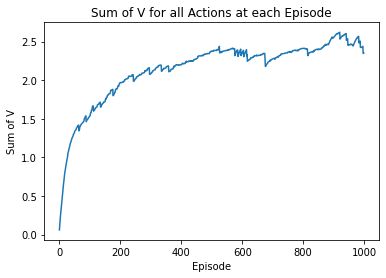

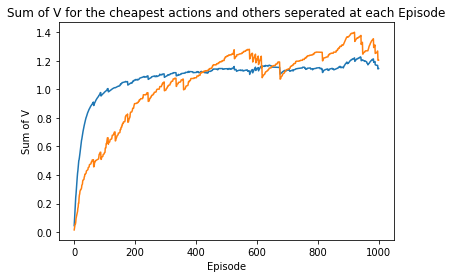

In [11]:
# Introduce simple rewards
budget10 = 30


alpha10 = 0.05
num_episodes10 = 1000
epsilon10 = 0.2


# Currently not using a reward
reward10 = [0.8,0,0,0.8,0,0,0,0,0]

start_time = time.time()

Mdl10 = MCModelv3(data=data, alpha = alpha10, e = num_episodes10,epsilon = epsilon10, budget = budget10, reward = reward10)

print("--- %s seconds ---" % (time.time() - start_time))

print(Mdl10[3])


plt.plot(range(0,num_episodes10), Mdl10[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes10), Mdl10[1],range(0,num_episodes10), Mdl10[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

--- 22.12254762649536 seconds ---
Ingredient
1    2
2    1
3    1
4    3
Name: Product, dtype: int64


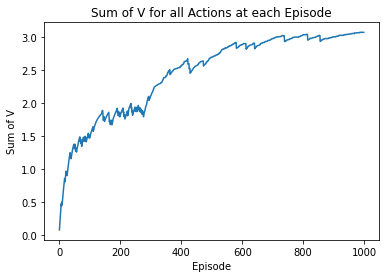

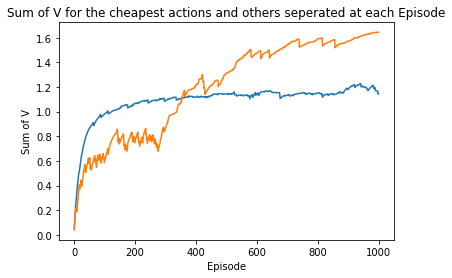

In [12]:
# Add rewards for more actions
budget11 = 30


alpha11 = 0.05
num_episodes11 = 1000
epsilon11 = 0.2


# Currently not using a reward
reward11 = [0.8,0.4,0.5,0.6,0.4,0.4,0.6,0.2,0.4]

start_time = time.time()

Mdl11 = MCModelv3(data=data, alpha = alpha11, e = num_episodes11,epsilon = epsilon11, budget = budget11, reward = reward11)

print("--- %s seconds ---" % (time.time() - start_time))

print(Mdl11[3])


plt.plot(range(0,num_episodes11), Mdl11[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes11), Mdl10[1],range(0,num_episodes11), Mdl11[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()